# Regresión lineal desde cero

Si estás acá en principio sabés que es una regresión lineal. Una regresión lineal una forma de analizar como ciertas variables dependen de otras.



Linear_regression.svg

Una regresión lineal, nos relaciona variables independientes o features  por medio se sumás y productos diferentes cantidades para obtener predecir un valor final.

Consideremos la llamada fórmula de Dulong. La formula de Dulong es un resultado experimental surgido de analizar la energía liberda en la combustión de combustibles fósiles. La formula predice el valor de energía liberada en función la proporción de cada elemento los productos de la combustión

$$E\left[\frac{kJ}{g}\right] = 38,2C + 84,9 (H − \frac{O}{8})  − 0,5l -  0,62s$$

Donde $C$ es la proporción en masa carbono en los productos, $H$ la proporción de hidrógeno, $O$ la de oxígeno, $l$ vale 1 solamente si el combustible es líquido, $s$ vale 1 solamente si el combustible es sólido

Por ejemplo, al quemar gas metáno, $C = 0.75$, $H = 0.25$ y $O = 0.00$

En nuestra fórmula eso nos devuelve $49.87\frac{kJ}{g}$ frente al valor $50.01\frac{kJ}{g}$ reportado en tablas.

Lo primero que diremos es que una regresión lineal es una neurona.

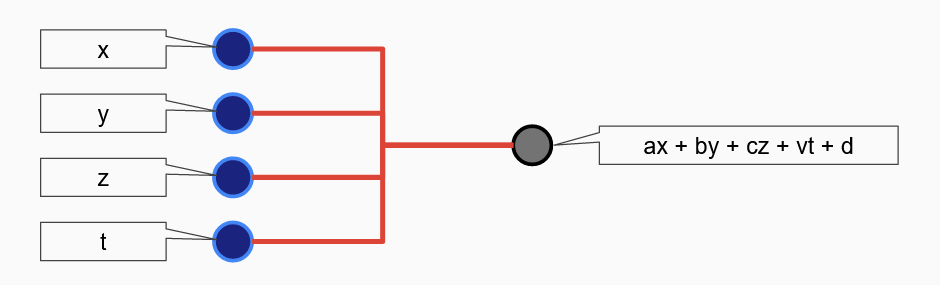

Una regresión lineal, tiene una serie de variables independientes que influyen en el resulatado de una variable dependiente. En le esquema anterior, tenemos 4 variables independientes y una dependiente.

Esta estructura es similar a una neutrona que recibe 4 estimulos y produce una única respuesta.

Además, la regresión lineal usando mínimos cuadrados, nos define una cantidad a minimizar. Es decir, el entrenamiento de nuestra neurona, consistirá en encontrar los parametos de que mejor permitan representar nuestos datos siguiendo una función lineal. En este contexto, a la cantidad a minimizar la llamaremos **función de pérdida**

Ahora, lo que describiremos será como es el proceso general para entrenar una red. Esto lo vimos en la clase pasada:

1. Carga de los datos
1. Separación de los datos en lotes
1. Inicialización de parámetros
1. Definición del modelo
1. Definición de la función de pérdida
1. Definición del algoritmo de optimización

Para nuestro primer ejemplo lo que haremos será trabajar con datos sintéticos. Es decir, tomaremos los datos generados de un modelo lineal. Nuestra intención con esto es múltiple:

* Queremos mostrar un ejemplo que nos permita entender el significado de los parámetros de nuestro modelo.
* Queremos saber que tan buenas son nuestras estimaciones
* Queremos usar un modelo sencillo que nos permita analizar cada paso del pipeline. 
* Queremos aprender un poco más en detalle como funciona cada paso del pipeline.

Este último punto es el principal motivo de esta parte. Por lo general, los frameworks de deep learning tiene multiples herramientas que nos permite simplificar cada uno de los pasos. Sin embargo, también es común que necesitemos ajustar detalles del modelo que usaremos. Es en este sentido que "reinventar la rueda", nos puede ayudar entender como funcionan las herramientas preexistentes en los frameworks que usaremos.

In [ ]:
%matplotlib inline
import random
import torch
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

## "Dataset"

Comencemos con un modelo lineal sencillo al que añadiremos ruido gaussiano

**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**

$$\mathbf{w} = [2, -3.4]^\top$$
$$b = 4.2$$


In [ ]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [ ]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Es importante ver cual es la dimensionalidad de nuestros features y nuestras etiquetas.


In [ ]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.9379,  0.7461]) 
label: tensor([-0.2267])


Podemos graficar la etiqueta y una de las features para ver este comportamiento lineal


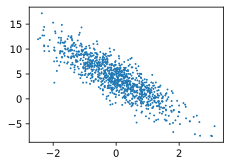

In [ ]:
backend_inline.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = (3.5, 2.5)
# Punto y coma para mostrar solo la figura
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);


## Cargando los datos

Dado que el entrenamiento se hace usando muchos mini-lotes de datos, es conveniente tener una función que se encarga de generar estos minilotes segun los necesitemos. 

Para esto necesitamos una función que tome nuestra matriz de diseño, tome nuestras etiquetas y nos genere lotes para el entrenamiento de un tamaño dado.



In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # aleatorizamos el orden de los datos
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [ ]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4190,  0.4473],
        [ 1.1642, -0.2739],
        [-0.4004,  0.3951],
        [ 0.7606,  0.4978],
        [ 0.3860, -0.5314],
        [ 0.6644, -1.6968],
        [-2.1084,  0.8029],
        [-0.2559, -0.2550],
        [-0.8431, -0.4689],
        [-0.0869,  0.3775]]) 
 tensor([[ 3.5298],
        [ 7.4593],
        [ 2.0516],
        [ 4.0260],
        [ 6.7843],
        [11.3005],
        [-2.7647],
        [ 4.5658],
        [ 4.0986],
        [ 2.7517]])


## Valores iniciales de nuestro modelo

Dado que estamos estamos buscando mínimos de una fución de pérdida, podemos elegir iniciar con cualquier valor. Luego nuestro optimizador se encargará de encontrar los mínimos adecuados.

In [ ]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

Con estos parametros iniciales, estamos en condiciones de empezar a entrenar nuestra red. Es decir, buscar los parámetros que mejor representen el comportamiento de nuestros datos.

Debemos recordar que detras del uso de descenso por gradiente, usamos herramientas de diferenciación automática para nuestros problemas.


## Definiendo el modelo.

En este caso, nuestro modelo será análogo al usado para generar nuestros datos, es decir: 

$$\mathbf{y} = \mathbf{Xw} + b$$



In [ ]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## Definiendo la función de pérdida

Como estamos haciendo una regresión lineal, sabemos que lo que minimizamos son es la cantidad llamada **mínimos cuadrados**

In [ ]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Definiendo el algoritmo de optimización

A continuación mostramos un pequeño ejemplo de funciona descenso gradiente estocástico 


In [ ]:
def sgd(params, lr, batch_size):
    """Usamos minilotes"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Entrenamiento

A continuación esbozamos como es nuestro ciclo de entrenamiento

* Iniciamos nuestros parametros. $(\mathbf{w}, b)$
* Repetimos hasta concluir
    * Calculamos la función de pérdida ${L} \leftarrow \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Calculamos el gradiente con minilotes $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * actualizamos los parámetros. $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
    > Nota: estos últimos dos pasos pasos los hace la función `sdg` definida arriba.

Llamamos **época** a cada vez que iteramos sobre todos nuestros datos. Por otro lado el parametro $η$ es lo que llamamos **tasa de aprendizaje** o **learning rate**. Este valor nos dice que tanto nos moveremos en la dirección hacia donde esta el mínimo. Tanto la cantidad de épocas a recorrer como la tasa de aprendizaje son **hiperparametros**. Encontrar lo hiperparámetros apropiados para nuestros datos y modelos no es una tarea sencilla. Por ahora daremos valores arbitrarios, pero aprender a encontrar valores correctos es todo un arte.


In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [ ]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # Funcion de perdida para nuestro minilote con `X` e `y`
        l = loss(net(X, w, b), y)  
        # Gradiente de la funcion l con respeto a [`w`, `b`]
        # Recordar w es un "vector" de parametros
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.040583
epoch 2, loss 0.000172
epoch 3, loss 0.000050


Como nuestros datos son sintéticos, podemos comparar nuestras estimaciones con los valores reales.


In [ ]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 8.5831e-05, -2.5415e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0004], grad_fn=<RsubBackward1>)


# Regresión lineal concisa.

En el notebook anterior, vimos un ejemplo de como implementar una red neuronal desde cero. Sin embargo, hacer esto es una mala idea. La principal razón por la que es una mala idea, es que muchas de las cosas que hicimos consisten en "reinventar la rueda". Hay bibliotecas que ya tienen herramientas para hacer lo que ya hicimos. Además, nuestra implementación puede no ser la más eficiente. Es decir: la implementación usada puede generar tiempos de espera que podrían ser evitados si nuestro código estuviera implementado de manera distinta. Por esta razón, es siempre recomendable usar las bibliotecas preexistentes.

Recordemos que el ejemplo anterior estaba pensado para que le perdamos el miedo a las bibliotecas preexistentes, para que entendamos como funcionan y para aprender a implementar cosas nuevas (si llegamos a necesitarlo)

Veamos entonces como implementariamos todo lo anterior haciendo uso de la biblioteca ``pytorch``


## Datos sintéticos


In [ ]:
import numpy as np
import torch
from torch.utils import data

Misma función que usamos anteriormente

In [ ]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [ ]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

## Cargando nuestros datos

En este caso, podemos enviar nuestros datos diferentes metodos preexistentes de `pytorch` para generar nuestro minilotes.

Además podemos pedir nos mezcle nuestros datos o que los deje tal cual


In [ ]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

Queremos ver como se generan nuestros minilotes. Para esto debemos poder imprimierlos por pantalla. A diferencia de la implementación anterior, el método `DataLoader`, no genera un iterable, por esto debemos convertirlo en uno y recorrerlo segun necesitemos


In [ ]:
next(iter(data_iter))

[tensor([[ 0.8729, -1.0049],
         [ 1.0513,  0.1398],
         [-0.4757,  0.1190],
         [-0.4710, -1.6177],
         [-0.9133, -0.4505],
         [-0.5789, -0.1649],
         [-2.0384,  1.6825],
         [-1.0189, -0.0491],
         [-0.1122, -0.6400],
         [ 0.4170,  1.5266]]), tensor([[ 9.3498],
         [ 5.8139],
         [ 2.8469],
         [ 8.7544],
         [ 3.9017],
         [ 3.6009],
         [-5.5900],
         [ 2.3316],
         [ 6.1272],
         [-0.1594]])]

## Definiendo el modelo

A continuación presentamos la versión concisa de nuestro modelo, luego la discutiremos.


In [ ]:
# `nn` = neural networks, redes neuronales
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

La clase `Sequiential` define todas las capas a aplicar de manera secuencial en nuestro modelo. Por ahora, como trabajamos con regresión lineal solo usaremos una capa. Sin embargo esta capa es lo que se llama una capa *totalmente conectada*. Es decir, esta representada por una matriz que aplica sobre vector de features. Al aplicar esta matriz encontramos la salida de nuestra neurona. En este caso, este tipo de capas se las conoce como `Linear` y reciben como entrada `(<numero_de_entradas>, <numero_de_salidas>)`. Para nuestro modelo, esto son nuestras 2 features y nuestra etiqueta.


¿Que es una capa con lineal?
------------------


una capa lineal o completamente conectada es la forma más básica de una red neuronal. Cada entrada influencia a cada salida de acuerdo a los pesos. Si nuestro modelo tiene $m$ entradas y $n$ salidas, la matriz de pesos sera $m \times n$. De igual modo el vector de sesgos o bias tendra dimensión $n$

In [ ]:
import torch

lin = torch.nn.Linear(2, 1)
x = torch.rand(1, 2)
print('entrada:')
print(x)

print('\n\nPesos y parametros:')
for param in lin.named_parameters():
    print(param)

y = lin(x)
print('\n\nsalida')
print(y)

# Al hacer la multiplicacion matricial correspondiente obtenemos nuesta salida.
x @ lin.weight.T + lin.bias

entrada:
tensor([[0.7142, 0.2259]])


Pesos y parametros:
('weight', Parameter containing:
tensor([[ 0.2879, -0.2711]], requires_grad=True))
('bias', Parameter containing:
tensor([0.1380], requires_grad=True))


salida
tensor([[0.2823]], grad_fn=<AddmmBackward0>)


tensor([[0.2823]], grad_fn=<AddBackward0>)

## Inicialización de parametros de nuestro modelo.

Por lo general, los frameworks prexistentes tienen implementaciones por defecto para inicializar los parámetros. Sin embargo, queremos iniciarlos de manera similar a la anterior.

Para ellos accedemos a la primera (y única capa) usando `net[0]`. Luego accedemos a los pesos y los sesgos con `weight.data` and `bias.data`. Finalmente rellenamos los valores con lo que teníamos pensado usar.


In [ ]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## Definiendo la función de pérdida


In [ ]:
loss = nn.MSELoss()

## Definiendo el algoritmo de optimización


La principal diferencia con lo que hicimos antes, es solamente debemos pasarle a nuestro `SDG`, los parametros a optimizar. El resto de los detalles ya son manejados por la implementación de `pytorch`. En este caso también estamos pasando la tasa de aprendizaje, pero la clase `SGD` de `pytorch` ya incluye un valor por defecto.

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

Un optimizador en `torch` tiene por defecto una serie de métodos. Sin embargo ahora mismo solo nos interesan 2 de ellos, pues son los que más usaremos.

* `Optimizer.step`
  > Este es el método es el que propiamente aplica el algoritmo SGD, o cualquier otro algoritmo que fueramos a implementar.
* `Optimizer.zero_grad`
  > Por defecto, `Optimizer` suma los sucesivos gradientes calculados. Esto hace que al principio de cada época de el entrenamiento, debamos setear el gradiente en 0. Es por esto que este método existe dentro de la clase `Optimizer`

## Entrenamiento

Hasta aquí veníamos reduciendo lineas de código de manera impresionante. Sin embargo, nuestro ciclo de entrenamiento será casi identico a lo que habíamos visto antes.
* Repetimos hasta concluir
    * Calculamos la función de pérdida
    * Calculamos el gradiente con minilotes 
    * Actualizamos los parámetros. 


In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000246
epoch 2, loss 0.000098
epoch 3, loss 0.000098


In [ ]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([-3.8147e-06, -1.8549e-04])
error in estimating b: tensor([0.0005])


Hasta aquí hemos trabajado con el problema de la regresión. Sin embargo, muchas veces lo que deseamos es clasificar segun clases discretas. De hecho, más adelante veremos que los grandes logros de las redes neuronales son en el area de clasificación. Para esto, a continuación hablaremos de Regresión Softmax y su aplicación en clasificación.